# 1. Softmax logistic regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data = pd.read_csv("data/MNIST_train.csv").values

X_data = data[:, 1:]
Y_data = data[:, [0]]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state = 0)

print("Number of training examples = " + str(X_train.shape[0]) )
print("Number of testing examples = " + str(X_test.shape[0]) )
print("Number of features = " +  str(X_train.shape[1]) )

Number of training examples = 31500
Number of testing examples = 10500
Number of features = 784


Text(0.5,1,'label is [5]')

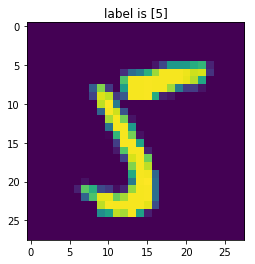

In [3]:
index = 10
sampleImg = np.reshape(X_train[index, :], [28, 28])

ax = plt.imshow(sampleImg)
plt.title("label is " + str(Y_train[index, :]))

Simple standardization for images

In [4]:
X_train = X_train / 255
X_test = X_test / 255

Convert labels to its one-hot encoding for defining the loss function of softmax classification

In [5]:
def one_hot_matrix(Y, num_class):
    """
    Convert an array of Y to its one_hot_matrix
    
    Arguments:
    Y -- array (number of examples, 1)
    num_class -- num of classes
    
    Return:
    Y_one_hot -- (number of examples, num_class)
    """
    Y_one_hot = np.zeros((Y.shape[0], num_class))
    Y_one_hot[np.arange(Y.shape[0]), Y.T] = 1
    
    return Y_one_hot

In [6]:
Y_train_one_hot = one_hot_matrix(Y_train, 10)
Y_test_one_hot = one_hot_matrix(Y_test, 10)

index = 2
print("Letter " + str(Y_train[index, 0]) + " converted to " + str(Y_train_one_hot[index, :]))

Letter 9 converted to [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## 1. Forward propagation
We treate the softmax classification problem as a 1-layer neural network with 10 nerons (add image). Each neural is just a linear combination of all input features, and the softmax activation function takes effect for all neurons.  

In [7]:
def linear_forward(X, W, b):
    """
    Arguments:
    X -- data matrix (num of examples, num of features)
    W -- weight matrix (num of features, num of classes)
    b -- bias vector (1, num of classes)
    
    Return: 
    Z -- input of activation function (num of examples, num of classes)
    """
    
    Z = np.dot(X, W) + b
    
    assert(Z.shape == (X.shape[0], W.shape[1]) )
    
    return Z

In [8]:
def soft_max(Z):
    """
    Arguments:
    Z -- (num of examples, num of classes)
    
    Return:
    A -- softmax matrix (num of examples, num of classes) 
    """
    exp_Z = np.exp(Z)
    A = exp_Z / exp_Z.sum(axis = 1, keepdims = True)
    
    assert(A.shape == Z.shape )
    
    return A

In [14]:
def initialize_parameters(num_feature, num_class):
    """
    Return:
    W -- (num of feature, num of class)
    b -- (1, num of class)
    """
    np.random.seed(1)
    W = np.random.randn(num_feature, num_class)
    b = np.zeros((1, num_class))
    
    return W, b

In [16]:
num_feature = X_train.shape[1]
num_class = 10

W, b = initialize_parameters(num_feature, num_class)
Z = linear_forward(X_train, W, b)
A = soft_max(Z)

assert(A.shape == (X_train.shape[0], num_class))
print(A[3, :].sum())

1.0


## 2. Compute the cost function
The cross entropy loss function for one example $i$ is $\mathcal{L}(a^{(i)}, y^{(i)}) = -\sum\limits_{j = 1}^{10} a^{(i)}_{j} \log y^{(i)}_{j}$. The overall loss is just the average of $\mathcal{L}$ over all training examples: $$J = \frac{1}{m} \sum\limits_{i = 1}^{m} \mathcal{L}(a^{(i)}, y^{(i)}) $$

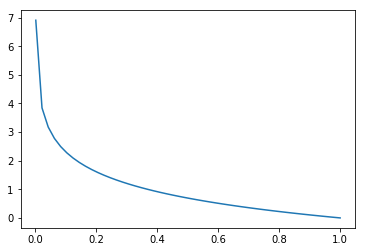

In [11]:
x = np.linspace(0.001, 1)
y = - np.log(x)
plt.plot(x, y)

If $a^{(i)} = 1$, the cost function want $y^{(i)}$ to be large while it heavily penalizes small $y^{(i)}$. 

In [12]:
def compute_cross_entropy_loss(A, Y):
    """
    Arguments:
    A -- prediction matrix of shape   (num of examples, num of class)
    Y -- one-hot matrix of true class (num of examples, num of class)
    Return:
    lost (scalar)
    """
    m = A.shape[0]
    return -(Y * np.log(A)).sum() / m
    

In [13]:
print(compute_cross_entropy_loss(A, Y_train_one_hot))

17.27404895524127


## 3. Backward propgation

We need to compute the partial derivatives of $w_{i, j}$ and $b_{j}$ with respect to $\mathcal{L}$ ($i$th input feature and $j$th neuron). Let's first write the formulas for forward propgation for one example $\{x_1, ..., x_{n} \}$ (use column vectors for legibility):

### Linear forward
$$
\begin{bmatrix} 
z_1 \\
\vdots \\
z_{10} \\
\end{bmatrix}
=
\begin{bmatrix} 
\sum\limits_{i=1}^{n} w_{i, 1} x_{i} \\
\vdots \\
\sum\limits_{i=1}^{n} w_{i, 10} x_{i} \\
\end{bmatrix}
+
\begin{bmatrix} 
b_1 \\
\vdots \\
b_{10} \\
\end{bmatrix}
$$

### Softmax
$$
\begin{bmatrix} 
z_1 \\
\vdots \\
z_{10} \\
\end{bmatrix}
\Rightarrow 
\begin{bmatrix} 
\frac{e^{z_1} }{\sum\limits_{k = 1}^{10} e^{z_k} } \\
\vdots \\
\frac{e^{z_10} }{\sum\limits_{k = 1}^{10} e^{z_k} } \\
\end{bmatrix}
=
\begin{bmatrix} 
a_1 \\
\vdots \\
a_{10} \\
\end{bmatrix}
$$

$$\mathcal{L}(a, y^{(i)}) = -\sum\limits_{j = 0}^{9} a^{(i)}_{j} \log y^{(i)}_{j}$$

$$\frac{\partial \mathcal{L}}{\partial w_{i, j}} = $$

### Derivative of the softmax function
Let $\Omega =  \sum\limits_{k = 1}^{10} e^{z_k}$, let compute the partial derivatives for the Jacobian matrix (10 x 10) $\frac{\partial a_p}{\partial z_q}$:

$$
\begin{split}
\text{if} \; p = q :& \frac{\partial a_p}{\partial z_p} = \frac{\partial \frac{e^{z_p}}{\Omega}}{\partial z_p} = \frac{e^{z_p}\Omega - e^{z_p}e^{z_p}}{\Omega^2} = \frac{e^{z_p}}{\Omega}\frac{\Omega - e^{z_p}}{\Omega} = \frac{e^{z_p}}{\Omega}(1-\frac{e^{z_p}}{\Omega}) =  y_p (1 - y_p)\\
\text{if} \; p \neq q :& \frac{\partial y_p}{\partial z_q} = \frac{\partial \frac{e^{z_p}}{\Omega}}{\partial z_q} = \frac{0 - e^{z_p}e^{z_q}}{\Omega^2} = -\frac{e^{z_p}}{\Omega} \frac{e^{z_1}}{\Omega} = -y_p y_q
\end{split}$$